# Understanding micrograd

Building up my understanding from the basics. Building up to a working MLP which can be trained to estimate

- A simple function plotted
- Calculating the derivative using the definition
- Calculating partial derivatives of a basic query
- Creating a Value object with the ability to:
  - record cumulative operations
  - extending it for operations: +, *, tanh(), exp(), -, /, pow(**), reverse of +,*
  - define gradient, the partial derivative, with respect to each operations
  - topological search for back propogration
- Manually calculating the partial derivative gradient at each Value
- DAG visual from the last Value object through the graph
- Modeling a neuron with multiple weights and bias using Value object
- Investigating activiation functions - tanh
- Building a multilayer perceptron using neurons organised into layers and manually calculation of gradients




In [2]:
import math, numpy as np, matplotlib.pyplot as plt, random

In [3]:
# defining a simple function and graphing it over data points
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

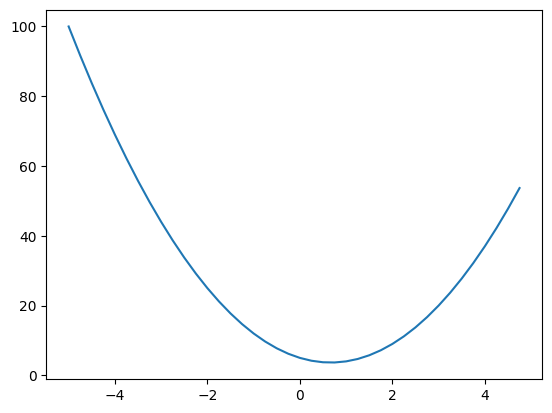

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
# derivation approximation of the function, min is at 2/3 which means a derivative approaches 0
h = 0.000001
x = 2/3
(f(x+h)-f(x))/h

2.999378523327323e-06

In [7]:
h = 0.00001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a +=h
d2 = a*b + c

# derivative with respect to a
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # dd/da = -3.0

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [176]:
# derivative with respect to b
h = 0.00001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b +=h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # dd/db = 2.0

d1 4.0
d2 4.00002
slope 2.0000000000131024


In [177]:
# derivative with respect to c
h = 0.00001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c +=h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # dd/dc = 1

d1 4.0
d2 4.00001
slope 0.9999999999621422


In [999]:
# creating the core value object with ability to:
# return value, add and multiply
# adding the ability to view the operations
# adding labels for each Value 
# adding a grad and initalise to 0
# inspect to see what values produce what other values
# __repr__ allows you to print out something when you return the instance
# add tanh operation
# add backwards closure functions for each operation
# add backward function to run the back prop using topological sort 
# ability to add and multiple numeric objects to Value object
# reverse multiple when numeric object is prior to Value object
# division using special case of n * (m**-1)


class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # function that doesn't do anything, for a leaf node for example
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self): 
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
        
    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad # power rule derivative
        out._backward = _backward

        return out
                          

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1 

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/ (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh' )

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
            
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # derivation of exp(x) is itself
        out._backward = _backward

        return out

    def backward(self):
            
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [243]:
a = Value(2)
b = Value(3)
a.data; a.grad
print(a.__dict__, b.__dict__)
c = a+ b 
print(c.__dict__)
x = c._prev.pop()
x.data

{'data': 2, 'grad': 0.0, '_backward': <function Value.__init__.<locals>.<lambda> at 0x119624e00>, '_prev': set(), '_op': '', 'label': ''} {'data': 3, 'grad': 0.0, '_backward': <function Value.__init__.<locals>.<lambda> at 0x119624ea0>, '_prev': set(), '_op': '', 'label': ''}
{'data': 5, 'grad': 0.0, '_backward': <function Value.__add__.<locals>._backward at 0x1196245e0>, '_prev': {Value(data=2), Value(data=3)}, '_op': '+', 'label': ''}


2

In [179]:
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')

a+b, a.__add__(b), a*b, a*b + c, (a.__mul__(b)).__add__(c)

(Value(data=-1), Value(data=-1), Value(data=-6), Value(data=4), Value(data=4))

In [180]:
d = a*b + c
d, d._prev, d._op

(Value(data=4), {Value(data=-6), Value(data=10)}, '+')

In [181]:
d._prev

{Value(data=-6), Value(data=10)}

In [182]:
next(iter(d._prev))._prev

{Value(data=-3), Value(data=2)}

In [247]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

In [248]:
# brew install graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        # dot.node(name=str(id(n)), label = "{ data %.4f }" % (n.data, ), shape='record')
        dot.node(name=str(id(n)), label = f"{{ {n.label} | data {n.data:.4f} | grad {n.grad:.4f} }}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


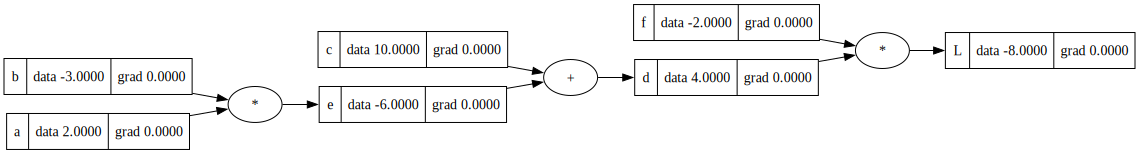

In [249]:
draw_dot(L)

In [186]:
L.grad = 1
d.grad = -2
f.grad = 4
c.grad = -2
e.grad = -2
a.grad = 6
b.grad = -4.0

# --
# L = d * f
# dL/dd = ?
# definition of derivative (f(x+h) - f(x)) / h
# dL/dd = (((d+h) * f) - d * f) / h
# dL/dd = ((df + hf - df) / h
# dL/dd = hf/h = f 
# --
# L = d * f
# dL/df = ((f+h) * d - df) / h = (fd+hd-df)/h = hd/h = d
# --
# dL/dc - the crux of neural networks and deep learning!
# dL/dc = dL/dd * dd/dc the chain rule
# d = e + c
# dd/dc = (e + c + h) - (e+c) / h = h/h = 1
# dd/de = 1 (by symetry)
# dL/dc = f * 1 = -2.0
# dL/de = dL/dd * dd/de = f * 1 = -2.0
# --
# dL/da = dL/de * de/da
# e = a * b
# de/da = ((a+h)b - ab) / h = b = -3.0
# dL/da = -2.0 * -3.0 = 6.0
# --
# dL/db = dL/de * de/db
# e = a * b
# de/db =  (a(b+h) - ab) / h =  ah/h = a = 2.0
# dL/db = -2.0 * 2.0 = -4.0

# """

In [187]:
# validating derivates
def grad_checker():

    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data +=h
    c = Value(10.0, label='c')
    e = a * b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    # f.data += h
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1) / h)
grad_checker()    

-4.000000000008441


In [190]:
# single opitimation step
# nudge values in the direction of gradient will make L less (value goes up)
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# rerun the forward pass
e = a * b
d = e + c
L = d * f

print(L.data)


-7.286496


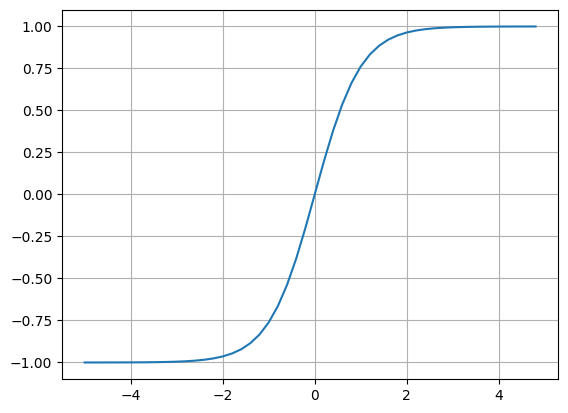

In [213]:
# a neutron model
# adding an activation function, example:

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [292]:
# building a neuron
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



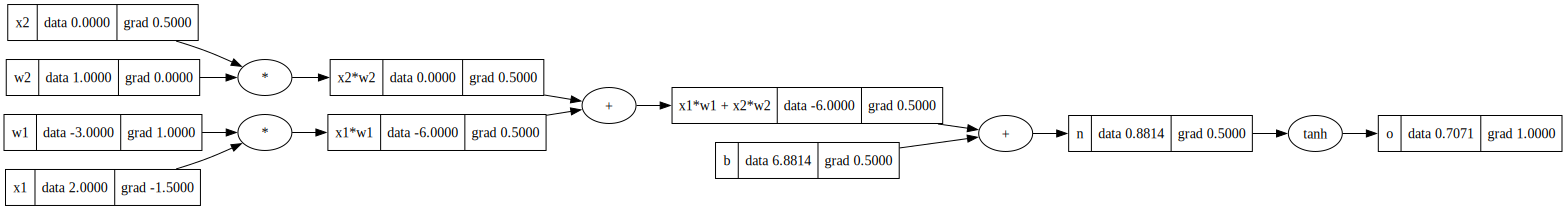

In [295]:
draw_dot(o)

In [290]:
# manual back propogation through the neuron
o.grad = 1.0
# o = n.tanh()
#do/dn = 1 - tanh(x) ** 2 = 1 - (0.7071) ** 2 = 0.5
n.grad = 0.5

x1w1x2w2.grad = n.grad
b.grad = n.grad
x2w2.grad = n.grad
x1w1.grad = n.grad
x2.grad = w2.data * x2w2.grad 
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad



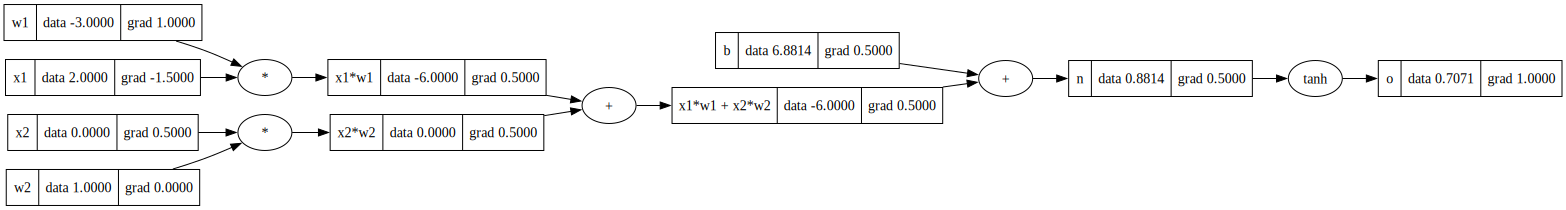

In [291]:
# now instead reinitiase the weights and bias in the neuron and run the gradient back propogation
draw_dot(o)

In [256]:
o.grad = 1.0

In [258]:
o._backward()

In [262]:
n._backward()
b._backward()

In [264]:
x1w1x2w2._backward()

In [266]:
x1w1._backward()
x2w2._backward()

In [277]:
# we want to start at the end and go back to the start when we run the steps of the backpropogation. 
# We need to go any step further upstream before running backprop on the node. Do get the correct order we use
# topological sorting. We take the DAG and sort the vertices so that for every directed edge u -> v, vertex v comes before u.
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

o.grad = 1.0
# then we can run backward on each node in the right order using the reversed topo list
for node in reversed(topo):
    print(node)
    node._backward()

Value(data=0.7071067811865476)
Value(data=0.8813735870195432)
Value(data=6.881373587019543)
Value(data=-6.0)
Value(data=0.0)
Value(data=0.0)
Value(data=1.0)
Value(data=-6.0)
Value(data=2.0)
Value(data=-3.0)


In [294]:
o.backward()

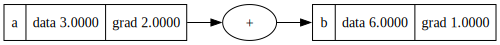

In [298]:
# bug to fix:
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

# db/db = 1
# db/da = 1 + 1 = 2 but it's one in calc
# the gradients are overwriting each other rather than accumulating



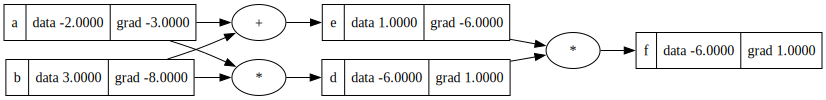

In [301]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label='d'
e = a + b; e.label='e'
f = d * e; f.label='f'
f.backward()
draw_dot(f)

# here a.grad and b.grad are incorrect as + operation has overwritten

In [304]:
# cant do this as numeric datatype can be added directly to the Value instance 
a = Value (1)
a + 1

Value(data=2)

In [307]:
# similarlly for multiplication
b = Value (2)
b * 3

Value(data=6)

In [322]:
b = Value(2)
2 * b

Value(data=4)

In [311]:
a = Value (1)
1 + a

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [331]:
# for division we can have a special way
a = Value(2.0)
b = Value(4.0)
a / b
# a * (1/b)
# a * (b**-1)

# instead make a general case of:
# x ** k


Value(data=0.5)

In [339]:
a = Value(data=5)
b = Value(data=2)

c = a/b

In [340]:
c.__dict__

{'data': 2.5,
 'grad': 0.0,
 '_backward': <function __main__.Value.__mul__.<locals>._backward()>,
 '_prev': {Value(data=0.5), Value(data=5)},
 '_op': '*',
 'label': ''}

In [347]:
val = list(c._prev)[1]
val.__dict__

{'data': 0.5,
 'grad': 0.0,
 '_backward': <function __main__.Value.__pow__.<locals>._backward()>,
 '_prev': {Value(data=2)},
 '_op': '**-1',
 'label': ''}

In [354]:
a= Value(3.0)
b = Value(2.0)
a - b

Value(data=1.0)

In [367]:
# building a neuron
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# --- break up tanh
# o = n.tanh(); o.label = 'o'
e = (2 * n).exp()
o = (e - 1)/(e + 1) 
# ---
o.backward()

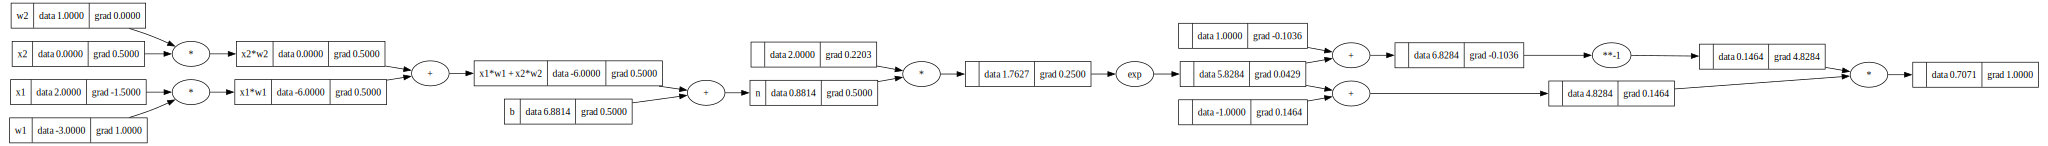

In [368]:
draw_dot(o)

In [370]:
4.8284 / 6.8284

0.7071056177142523

In [382]:
# doing the same with pytorch.
# explictly state that all nodes have gradients
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b  = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n  = x1*w1 + x2*w2 + b
o  = torch.tanh(n)

print(o.data.item())
o.backward()
# grads match to our examples
print('---')
print('w2',w2.grad.item())
print('x2',x2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7071066904050358
---
w2 0.0
x2 0.5000001283844369
x1 -1.5000003851533106
w1 1.0000002567688737


In [373]:
x1

tensor([2.], dtype=torch.float64, requires_grad=True)

In [375]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [377]:
torch.Tensor([2.0]).dtype # default is float32 but we want float64 (double) which is the same as python

torch.float32

In [388]:
o.item(), o.data.item(), x1.grad.item()

(0.7071066904050358, 0.7071066904050358, -1.5000003851533106)

In [ ]:
"""
What have we learnt so far:

defining a basic function and graphing it
computing it's derivite for certain values
building a value object which records operations performed for add and substract
extending the value object to record children, label and operations
visualse presenting the value object as a DAG
performing manual back propgration using partial derivatition and the chain rule to understand the impact of each variable
creating closure functions in the value object to perform the back propgation automatically
build a dependent list using topological search to workout the order to apply back propgation in
adding backpropgation to create this list and backprop through the Value instance tree
applying Value to model a neuron
investigating activiation functions and tanh
extending Value object to tanh and it's derivative
dealing with reverse ops for addition and multiplication
dealing with int and float numbers adding to Value 
extending value object to the exponential definition of tanh using pow, subtraction and expotentials
showing these graphically
demonstrating how to do the same with pytorch and calculation of backprogations results
"""

In [1001]:
class Neuron: 
    
    def __init__(self, nin):
        # print(f'setup neuron: {nin} inputs + bias')
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):   
        # print(f'neuron : calc output from {len(x)} inputs')
        act = sum((wi * xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        # print(f"setup layer : {nout} neurons")
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # print(f'layer  : calc layer output')
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     paramas.extend(ps)
        # return params

class MLP:

    def __init__(self, nin, nouts):
        # print(f'setup mlp   : {nouts} layers')
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            # print(f'mlp    : pass {len(x)} calculated outputs to layer')
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# n = Neuron(2)
# x = [2.0, 3.0]
# n(x)

# l = Layer(2,3)

# print(l([2.0, 3.0]))
# print('---')

# for n in l.neurons:
#     print(n.w, n.b)


n = MLP(3, [4, 4, 1])
x = [2.0, 3.0, -1.0]
n(x)
# n.layers

Value(data=-0.6414028050468273)

In [ ]:
draw_dot(n(x))

In [520]:
Value(3) + 3.0
3.0 + Value(3)

Value(data=6.0)

In [425]:
sum([1,2,3]), sum([1,2,3],3) # second sum param adds the result to the sum

(6, 9)

In [732]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.828647337660683),
 Value(data=0.9613764151886546),
 Value(data=0.9260761523403511),
 Value(data=0.95002429682839)]

In [688]:
# mean squared error loss. You get zero if the out and the pred is the same, the more you're off the greater the loss will be.
# [(yout- ygt)**2 for ygt, yout in zip(ys, ypred)]
loss = sum([(yout- ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.51073189238054)

In [679]:
loss.backward()

In [681]:
n.layers[0].neurons[0].w[0].grad

0.19428151235008395

In [ ]:
draw_dot(loss)

In [682]:
n.layers[0].neurons[0].w[0].data

-8

In [566]:
loss

Value(data=6.293722131243563)

In [994]:
# this is gradient descent:

# forward pass
ypred = [n(x) for x in xs]
loss = sum([(yout- ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.0007521597815551142)

In [995]:
# backward pass
loss.backward()

In [996]:
# update parameters 
for p in n.parameters():
    p.data += -0.0005 * p.grad 

In [997]:
ypred

[Value(data=0.9881852067711676),
 Value(data=-0.9820997151400154),
 Value(data=-0.9901350358428653),
 Value(data=0.9860417505888129)]

In [998]:
n.parameters()

[Value(data=0.6572703821390008),
 Value(data=0.6578707518214094),
 Value(data=-1.1643815564483846),
 Value(data=-0.30828742772335593),
 Value(data=-0.219309005595846),
 Value(data=-1.4652091153087548),
 Value(data=1.5426267065036987),
 Value(data=0.31133372952012484),
 Value(data=-0.5782791659572286),
 Value(data=-0.10755021327984024),
 Value(data=0.4720594999482675),
 Value(data=0.4372468175091597),
 Value(data=1.023613199545252),
 Value(data=-0.7180801778439329),
 Value(data=-1.1684437228603775),
 Value(data=-0.10426172282995379),
 Value(data=0.13650308589527188),
 Value(data=-0.9683363981602073),
 Value(data=0.5554887156172308),
 Value(data=-0.27435811437951957),
 Value(data=-0.058673344137741924),
 Value(data=-0.8959708821878248),
 Value(data=0.8990569606571657),
 Value(data=0.26131527886629186),
 Value(data=-1.1701965212380891),
 Value(data=0.800741544159937),
 Value(data=0.2502247400082775),
 Value(data=-0.6959469543436472),
 Value(data=-0.19116483055837782),
 Value(data=-1.08875

In [1139]:
## initialise the MLP 
n = MLP(3, [4, 4, 1])

## set up training set
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.3215735356276752),
 Value(data=-0.3704913348471981),
 Value(data=-0.39638679470952115),
 Value(data=-0.5242963254364683)]

In [1140]:
for k in range(10):
    # forward pass
    ypred = [n(x) for x in xs] # determine current predictions
    loss = sum([(yout- ygt)**2 for ygt, yout in zip(ys, ypred)]) # calculate the loss
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update params
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)


0 4.830665958914063
1 3.848675265195377
2 3.4246805269679452
3 2.8773355910748357
4 2.244061023510251
5 1.7746120297611827
6 1.3709201217818208
7 1.0151205364430937
8 0.7408845475278767
9 0.5516889686624854


In [1026]:
ypred

[Value(data=-0.10433632874372444),
 Value(data=0.5533245770131929),
 Value(data=-0.09724206982117163),
 Value(data=-0.2675127710365069)]

In [1054]:
d = n.layers[1].neurons[1].w[1].data
g = n.layers[1].neurons[1].w[1].grad
print (d,g)

n.layers[1].neurons[1].w[1].data = -0.03 # -0.05404385163249947



-0.03 -1943.525413691898


In [1057]:
ypred = [n(x) for x in xs] # determine current predictions
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]) # calculate the loss
# backward pass
for p in n.parameters():
    p.grad = 0.0
loss.backward()
loss

Value(data=6.038236006615932)

In [1150]:
# investigate how by adjusting one neuron, the grad and loss alters given a distribution of values
# by rerunning this you can see that the gradient profile and loss related to variations for a given neuron.

# setup 
## initialise the MLP 
n = MLP(3, [4, 4, 1])

## set up training set
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

results = []

for n_data in np.arange(-6, 6, 0.25):
    n.layers[1].neurons[1].w[1].data = n_data
    ypred = [n(x) for x in xs] # determine current predictions
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]) # calculate the loss
    n_grad = n.layers[1].neurons[1].w[1].grad

    # backpropagate - calc grads
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    n_data_new_val = n_data + -0.05 * n_grad

    # show neuron data val and grad and current loss
    print(f"{n_data:5} | {n_grad:6.3f} | {loss.data:.5f} | {n_data_new_val:.4f}")
    results.append((n_data, n_grad, loss.data))
    
n_data, n_grad, loss =zip(*results)    

 -6.0 |  0.000 | 3.76419 | -6.0000
-5.75 | -0.035 | 3.75507 | -5.7482
 -5.5 | -0.038 | 3.74535 | -5.4981
-5.25 | -0.040 | 3.73506 | -5.2480
 -5.0 | -0.042 | 3.72426 | -4.9979
-4.75 | -0.044 | 3.71309 | -4.7478
 -4.5 | -0.045 | 3.70174 | -4.4977
-4.25 | -0.045 | 3.69053 | -4.2477
 -4.0 | -0.044 | 3.67996 | -3.9978
-3.75 | -0.040 | 3.67078 | -3.7480
 -3.5 | -0.033 | 3.66414 | -3.4984
-3.25 | -0.019 | 3.66176 | -3.2490
 -3.0 |  0.002 | 3.66618 | -3.0001
-2.75 |  0.036 | 3.68113 | -2.7518
 -2.5 |  0.087 | 3.71201 | -2.5044
-2.25 |  0.165 | 3.76639 | -2.2582
 -2.0 |  0.277 | 3.85442 | -2.0139
-1.75 |  0.436 | 3.98866 | -1.7718
 -1.5 |  0.648 | 4.18241 | -1.5324
-1.25 |  0.910 | 4.44547 | -1.2955
 -1.0 |  1.195 | 4.77683 | -1.0597
-0.75 |  1.444 | 5.15765 | -0.8222
 -0.5 |  1.578 | 5.55125 | -0.5789
-0.25 |  1.542 | 5.91526 | -0.3271
  0.0 |  1.349 | 6.21867 | -0.0674
 0.25 |  1.071 | 6.45073 | 0.1964
  0.5 |  0.790 | 6.61726 | 0.4605
 0.75 |  0.552 | 6.73165 | 0.7224
  1.0 |  0.373 | 6.8079

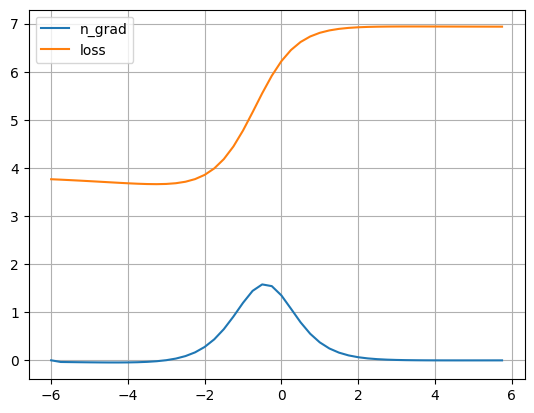

In [1151]:
plt.plot(n_data, n_grad, label = 'n_grad')
plt.plot(n_data, loss, label = 'loss')
plt.legend()
plt.grid(True)
plt.show()